In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy


## Define some variables and set constants

In [115]:
num_input_parameters = 6
num_output_parameters = 1
learning_rate = 0.1
num_steps = 2000
batch_size = 10
num_neurons = 6

#initial values
S0 = 1
V0 = 0.2

#bounds for a,b,c,rho,T,K
bounds = np.array([[1,3],[0.1,0.6],[0,0.1],[0,1],[1,2],[0.6,1.3]])

scaler = MinMaxScaler()

X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

## Next Batch using Heston "closed form"

In [116]:
#input:
#output: Call option price with strike K and Maturity T
def heston_closed(a,b,c,T,K,rho,V0,S0,r=0):
    
    def char_f(w,a,b,c,T,K,rho,V0,S0,r):
        alpha = -0.5*w*(w+complex(0,1))
        beta = a - rho*c*w*complex(0,1)
        gamma = c*c/2
        h = cmath.sqrt(beta*beta-4*alpha*gamma)
        rplus = (beta + h)/c/c
        rminus = (beta - h)/c/c
        g = rminus/rplus
        D =  rminus*(1-cmath.exp(-h*T))/(1-g*cmath.exp(-h*T))
        C = a*(rminus*T-2/c/c*cmath.log((1-g*cmath.exp(-h*T))/(1-g)))
        return cmath.exp(C*b+D*V0+complex(0,1)*w*cmath.log(S0*cmath.exp(r*T)))

    def integrand1(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w-i,a,b,c,T,K,rho,V0,S0,r)/i/w/char_f(-i,a,b,c,T,K,rho,V0,S0,r)).real
    
    def integrand2(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w,a,b,c,T,K,rho,V0,S0,r)/i/w).real
    
    pi1 = 0.5 + quad(integrand1,0,np.inf)[0]/np.pi
    pi2 = 0.5 + quad(integrand2,0,np.inf)[0]/np.pi
    
    return (S0*pi1 + cmath.exp(-r*T)*K*pi2).real

In [117]:
#input: batch_size, bounds for a,b,c,rho in that order 
#output: X_batch,y_batch
def next_batch_heston_train(batch_size,bounds):
    #for heston X contains values for a,b,c,rho,T,K and S0,V0 are kept fixed for now
    X = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))
    
    X[:,0] = uniform.rvs(size=batch_size)*(bounds[0][1]-bounds[0][0]) + bounds[0][0]#a
    X[:,1] = uniform.rvs(size=batch_size)*(bounds[1][1]-bounds[1][0]) + bounds[1][0] #b
    X[:,2] = uniform.rvs(size=batch_size)*(bounds[2][1]-bounds[2][0]) + bounds[2][0] #c
    X[:,3] = uniform.rvs(size=batch_size)*(bounds[3][1]-bounds[3][0]) + bounds[3][0] #rho
    X[:,4] = uniform.rvs(size=batch_size)*(bounds[4][1]-bounds[4][0]) + bounds[4][0] #maturities T 
    X[:,5] = uniform.rvs(size=batch_size)*(bounds[5][1]-bounds[5][0]) + bounds[5][0] #strikes K

    
    for i in range(batch_size):
        y[i,0] = heston_closed(X[i,0],X[i,1],X[i,2],X[i,4],X[i,5],X[i,3],V0,S0)
    
    #X = scaler.fit_transform(X)
    #y = scaler.fit_transform(y)
    
    return X,y

## Next Batch using Euler Maruyama MC

In [118]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

In [119]:
def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

In [120]:
#work in progress
def heston(a,b,c,T,W,Z,V0,S0):
    #assert(2*a*b > c*c) 
    
    def mu2(V,i,k):
        return np.multiply(a,(b-V))
    
    def sigma2(V,i,k):
        return np.multiply(c,np.sqrt(np.maximum(0.0,V)))
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(np.sqrt(np.maximum(0.0,V[i,k])),S)
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

In [121]:
#input: batch_size, bounds for a,b,c,rho in that order 
#output: X_batch,y_batch
def next_batch_heston_EM_train(batch_size,bounds):
    X = np.zeros((batch_size,num_input_parameters))
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled = uniform.rvs(size=(batch_size,num_input_parameters))
    
    X = reverse_transform_tuple(X_scaled,num_input_parameters)

    n = 100
    dim = 10
        
    for i in range(batch_size):
        W,Z = corr_brownian_motion(n,X[i,4],dim,X[i,3])
        S,V = heston(X[i,0],X[i,1],X[i,2],X[i,4],W,Z,V0,S0)
        S_T = S[:,n]
        
        y[i,0] = np.mean(np.maximum(S_T-X[i,5],np.zeros(dim)))
    
    #X = scaler.fit_transform(X)
    #y = scaler.fit_transform(y)
    
    return X_scaled,y

In [122]:
def reverse_transform(X,n):
    res = np.zeros(len(X))
    for i in range(n):
        res[i] = X[i]*(bounds[i][1]-bounds[i][0]) + bounds[i][0]
    return res

def reverse_transform_tuple(X,n):
    res = np.zeros(X.shape)
    for i in range(n):
        res[:,i] = X[:,i]*(bounds[i][1]-bounds[i][0]) + bounds[i][0]
    return res

In [123]:
def transform(X,n):
    res = np.zeros(len(X))
    for i in range(n):
        res[i] = (X[i] - bounds[i][0])/(bounds[i][1]-bounds[i][0])
    return res

def transform_tuple(X,n):
    res = np.zeros(X.shape)
    for i in range(n):
        res[:,i] = (X[:,i] - bounds[i][0])/(bounds[i][1]-bounds[i][0])
    return res

## Design Neural Network and Train

In [124]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
hidden2 = fully_connected(hidden1, num_neurons, activation_fn=tf.nn.elu)
hidden3 = fully_connected(hidden2, num_neurons, activation_fn=tf.nn.elu)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)

outputs = fully_connected(hidden4, num_output_parameters, activation_fn=None)

In [125]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

In [126]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [127]:
init = tf.global_variables_initializer()

In [128]:
saver = tf.train.Saver()

In [129]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        #X_batch,Y_batch = next_batch_heston_train(batch_size,bounds)
        X_batch,Y_batch = next_batch_heston_EM_train(batch_size,bounds)

        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 200 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    #saver.save(sess, "./models/heston_closed_nn")
    saver.save(sess, "./models/heston_closed_EM_nn")

0 	RMSE: 0.22620244
200 	RMSE: 0.028947737
400 	RMSE: 0.023599029
600 	RMSE: 0.0139730405
800 	RMSE: 0.040797424
1000 	RMSE: 0.028215546
1200 	RMSE: 0.06529914
1400 	RMSE: 0.07188104
1600 	RMSE: 0.038820125
1800 	RMSE: 0.060629677


## Optimze for Market Parameter

In [130]:
theta_true = [1.1,0.2,0.25,0.4]
T = [1.1,1.15,1.2,1.3,1.4,1.5,1.6,1.7]
K = [0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]

In [131]:
def NNprediction(x):
    x = transform(x.T,4)
    tmp = np.zeros((1,6))
    tmp[0,:] = x

    return sess.run(outputs,feed_dict={X: tmp})

def NNgradientpred(x):
    x = np.asarray(x)
    x = transform(x.T,4)
    tmp = np.zeros((1,6))
    tmp[0,:] = x
    num_parameters = num_input_parameters-2
    grad = np.zeros(num_parameters)
    
    delta = 0.00000001
    for i in range(num_parameters):
        h = np.zeros(tmp.shape)
        h[0,i] = delta
        
        #two point gradient
        #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

        #four point gradient
        grad[i] = (-sess.run(outputs,feed_dict={X: tmp+2*h})+8*sess.run(outputs,feed_dict={X: tmp+h})-8*sess.run(outputs,feed_dict={X: tmp-h}) +sess.run(outputs,feed_dict={X: tmp-2*h}))/12/delta

    return grad

In [132]:
#input: theta in order a,b,c,rho
def CostFuncLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]

    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]
   
    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_

    return np.abs((NNprediction(x)-heston_closed(theta_true[0],theta_true[1],theta_true[2],x[0,4],x[0,5],theta_true[3],V0,S0))[0,:])


def JacobianLS(theta,i,j):
    #set T,K here
    T_ = T[i]
    K_ = K[j]
    if theta[3]<=0:
        theta[3] = 0.01
    if theta[3]>=1:
        theta[3] = 0.99
    if theta[2]<=0:
        theta[2] = 0.1
    if 2*theta[0]*theta[1]<=theta[2]*theta[2]:
        theta[0] += theta[2]
        theta[1] += theta[2]

    x = np.zeros((1,6))
    x[0,0:4] = theta
    x[0,4] = T_
    x[0,5] = K_

    return NNgradientpred(x).T

In [133]:
with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn")   

    init = [bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]]
    init_best = init

    cost_old = 1000000
    n = 4
    for a in range(n):
        init_new = [bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]]
        init_new[0] += 1/(n+1)*(bounds[0,1]-bounds[0,0])
        for b in range(n):
            init_new[1] += 1/(n+1)*(bounds[1,1]-bounds[1,0])
            init_new[2] = bounds[2,0]
            init_new[3] = bounds[3,0]
            for c in range(n):
                init_new[2] += 1/(n+1)*(bounds[2,1]-bounds[2,0])
                init_new[3] = bounds[3,0]
                for d in range(n):
                    init_new[3] += 1/(n+1)*(bounds[3,1]-bounds[3,0])
                    
                    cost_new = CostFuncLS(init_new,0,0)
                    if cost_new < cost_old:
                        init_best = init_new 
                    cost_old = cost_new

    init = init_best
print(init)

INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn
[1.4, 0.5, 0.08000000000000002, 0.8]


In [134]:
init_transformed = transform(init,4)
print(init_transformed)

[0.2 0.8 0.8 0.8]


In [135]:
bnds = ([bounds[0,0],bounds[1,0],bounds[2,0],bounds[3,0]],[bounds[0,1],bounds[1,1],bounds[2,1],bounds[3,1]])


with tf.Session() as sess:                          
    #saver.restore(sess, "./models/heston_closed_nn") 
    saver.restore(sess, "./models/heston_closed_EM_nn")   
 
    Theta = np.zeros((len(T),len(K),len(init)))
    for i in range(len(T)):
        for j in range(len(K)):
            I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,args=(i,j),verbose=0)
            Theta[i,j,:] = I.x
          

INFO:tensorflow:Restoring parameters from ./models/heston_closed_EM_nn


In [136]:
#print(Theta)

In [137]:
print("Mean of Predicted Theta: ",np.mean(np.mean(Theta,axis=0),axis=0))
print("True Theata: ",theta_true) 

Mean of Predicted Theta:  [1.39999969 0.49999969 0.07999994 0.79999939]
True Theata:  [1.1, 0.2, 0.25, 0.4]


In [138]:
RMSE = 0
price_true = np.zeros((len(T),len(K)))
price_opt_params = np.zeros((len(T),len(K)))
for i in range(len(T)):
    for j in range(len(K)):
        #price_true = heston_closed(theta_true[0],theta_true[1],theta_true[2],T[i],K[j],theta_true[3],V0,S0)
        n = 100
        dim = 20
        W,Z = corr_brownian_motion(n,T[i],dim,theta_true[3])
        S,V = heston(theta_true[0],theta_true[1],theta_true[2],T[i],W,Z,V0,S0)
        S_T = S[:,n]
        price_true[i,j] = np.mean(np.maximum(S_T-K[j],np.zeros(dim)))
        
        #price_opt_params = heston_closed(Theta[i,j,0],Theta[i,j,1],Theta[i,j,2],T[i],K[j],Theta[i,j,3],V0,S0)
        W,Z = corr_brownian_motion(n,T[i],dim,Theta[i,j,3])
        S,V = heston(Theta[i,j,0],Theta[i,j,1],Theta[i,j,2],T[i],W,Z,V0,S0)
        S_T = S[:,n]
        price_opt_params[i,j] = np.mean(np.maximum(S_T-K[j],np.zeros(dim)))
        RMSE += np.power(price_true[i,j]-price_opt_params[i,j],2)
RMSE = np.sqrt(RMSE/(len(T)*len(K)))
print("RMSE: ", RMSE)

RMSE:  0.014882377289821601


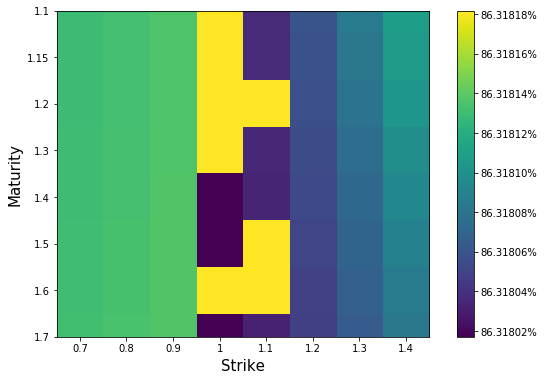

In [139]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


err = np.mean((100*np.abs((theta_true-Theta)/theta_true)),axis=2)
#print("Relative error in percent: ",err)
plt.figure(1,figsize=(10,6))
ax=plt.subplot(1,1,1)
plt.imshow(err.reshape(len(T),len(K)))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_yticks(np.linspace(0,len(T)-1,len(T)))
ax.set_yticklabels(T)
ax.set_xticks(np.linspace(0,len(K)-1,len(K)))
ax.set_xticklabels(K)

plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)



plt.show()

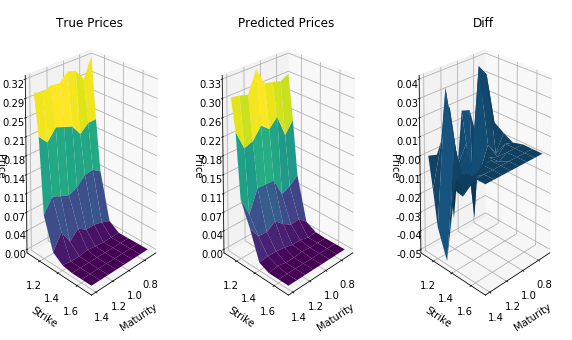

In [164]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(10, 6))

T_ = np.zeros((len(T),len(K)))
K_ = np.zeros((len(T),len(K)))
for i in range(len(K)):
    for j in range(len(T)):
        T_[j,i] = T[i]
        K_[i,j] = K[j]
for j in range(len(T)):   
    for i in range(len(K)):
        K_[j,i] = K[j]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=price_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Maturity')
ax1.set_ylabel('Strike')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=price_opt_params, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Maturity')
ax2.set_ylabel('Strike')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=price_true-price_opt_params, rstride=1, cstride=1, edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Maturity')
ax3.set_ylabel('Strike')
ax3.set_zlabel('Price')
ax3.set_title('Diff')
ax3.view_init(15, 45)



plt.show()